In [1]:
# EDA and data handling
import numpy as np 
import pandas as pd 
import pickle

import os
import matplotlib.pyplot as plt

# Modeling
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics

In [2]:
sklearn.__version__

'0.21.2'

In [3]:
horror_flicks=pd.read_csv('../data/horror_flicks.csv')
horror_flicks.head()

,title,overview,release_date,year,top_genre
0,Psycho,When larcenous real estate clerk Marion Crane ...,1960-06-22,1960,Horror
1,Sleep Has Her House,The shadows of screams climb beyond the hills....,2017-01-01,2017,Horror
2,Antrum,"Rumored to have been lost, Antrum appears as a...",2018-10-14,2018,Horror
3,The Silence of the Lambs,Clarice Starling is a top student at the FBI's...,1991-02-01,1991,Horror
4,House of the Disappeared,"After 25 years of imprisonment for familicide,...",2017-04-05,2017,Horror


In [4]:
movies = pd.read_csv('../data/tmdb_movie_plots.csv')
movies.shape

(3410, 22)

In [5]:
movies=pd.concat([movies, horror_flicks])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [6]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,top_genre,vote_average,vote_count,year
0,237000000.0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995.0,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2.787965e+09,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,Action,7.2,11800.0,2009
1,300000000.0,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285.0,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,9.610000e+08,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,Adventure,6.9,4500.0,2007


In [7]:
movies = movies[['title', 'overview', 'year', 'top_genre']].copy()

In [8]:
 movies.isnull().sum()

title        0
overview     5
year         0
top_genre    0
dtype: int64

In [9]:
# remove unlabeled data
print(movies.shape)
movies=movies.dropna(how='any')
print(movies.shape)

(3890, 4)
(3885, 4)


In [10]:
# columns
movies.columns

Index(['title', 'overview', 'year', 'top_genre'], dtype='object')

### Preprocess text data

In [11]:
tvec = TfidfVectorizer(
#                        input='content', 
#                        encoding='utf-8', 
#                        decode_error='strict', 
                       strip_accents='unicode', 
                       lowercase=True, 
#                        preprocessor=None, 
#                        tokenizer=None, 
#                        analyzer='word', 
                       stop_words='english', 
#                        token_pattern='(?u)\\b\\w\\w+\\b', 
#                        ngram_range=(1,3), 
#                        max_df=1.0, 
#                        min_df=1, 
#                        max_features=None, 
#                        vocabulary=True, 
#                        binary=False, 
#                        dtype=<class 'numpy.int64'>, 
#                        norm='l2', 
#                        use_idf=True, 
#                        smooth_idf=True, 
#                        sublinear_tf=False
)

## Target

In [12]:
# check out the genres
movies['top_genre'].value_counts().head()

Drama        826
Comedy       789
Horror       690
Action       513
Adventure    212
Name: top_genre, dtype: int64

In [13]:
# create the target variable
choice='Horror'
movies['target']=0
movies.loc[movies['top_genre']==choice, 'target']=1
movies['target'].value_counts().sort_index()

0    3195
1     690
Name: target, dtype: int64

In [14]:
# examine a few
movies[movies['target']==1].sample(3)

,title,overview,year,top_genre,target
362,The Beyond,When New Yorker Liza Merril inherits an old ho...,1981,Horror,1
373,The Ghost Breakers,After intrepid working girl Mary Carter become...,1940,Horror,1
153,Tucker and Dale vs. Evil,Two hillbillies are suspected of being killers...,2010,Horror,1


## Train-test split

In [15]:
np.random.seed(42) 
msk = np.random.rand(len(movies)) < 0.8
train = movies[msk]
test = movies[~msk]
print(len(train))
print(len(test))

3106
779


In [16]:
# How many in the test class?
print(test['target'].value_counts())

0    625
1    154
Name: target, dtype: int64


In [17]:
# How many in the train class?
print(train['target'].value_counts())

0    2570
1     536
Name: target, dtype: int64


In [18]:
# Undersample the majority class
undersample = train[train['target']==0].sample(600, random_state=42)
train_aug=train[train['target']==1].append(undersample)
train_aug['target'].value_counts()

0    600
1    536
Name: target, dtype: int64

In [19]:
# split into X and y
X_train=train_aug['overview']
X_test=test['overview']
y_train=train_aug['target']
y_test=test['target']

In [20]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

1136
1136
779
779


In [21]:
# Note the difference in train and test. Don't fit on the test data! (d'oh)
tvec.fit(X_train)
Xvec_train = tvec.transform(X_train)
Xvec_test  = tvec.transform(X_test)
# We pickle tvec later on.

In [22]:
# # grid search parameters
# param_grid = {
# #         'n_estimators': [100, 'warn'], 
# #         'max_depth': [3, 4, 5, None],
# #         'min_samples_split': [2, 3, 4, 5],
# #         'min_samples_leaf': [1, 2, 3, 4, 5],         
# #         'max_features': [5, 10, 15, 'auto'], 
# #         'class_weight': [None],
# #         'criterion':['entropy', 'gini'],
#         }

In [23]:
# # conduct gridsearch
# grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, n_jobs = 1, cv=3, verbose=False)
# grid.fit(Xvec_train, y_train)
# print(grid.best_params_)

In [24]:
# # Instantiate model using those parameters
# my_model = grid.best_estimator_
# print(my_model)
# Model parameters
# print(my_model.get_params)

In [25]:
my_model=RandomForestClassifier()
my_model.fit(Xvec_train, y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
# pickle the RF model
file = open(f'trained_rf_model.pkl', 'wb')
pickle.dump(my_model, file)
file.close()

## Predict & Evaluate

In [27]:
# Predict on the test data
y_preds=my_model.predict(Xvec_test)
print(len(y_test))
len(y_preds)

779


779

In [28]:
# Probabilities
y_probs = my_model.predict_proba(Xvec_test)[:,1]
len(y_probs)

779

In [29]:
# Accuracy score
metrics.accuracy_score(y_test, y_preds)

0.7406931964056482

In [30]:
# precision and recall 
print(metrics.classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83       625
           1       0.37      0.44      0.40       154

    accuracy                           0.74       779
   macro avg       0.61      0.63      0.62       779
weighted avg       0.76      0.74      0.75       779



In [31]:
# confusion matrix
cm = metrics.confusion_matrix(y_test, y_preds)
pd.DataFrame(cm, columns=['pred_0', 'pred_1'])

,pred_0,pred_1
0,509,116
1,86,68


In [32]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_preds).ravel()
print(tn, fp, fn, tp)

509 116 86 68


## ROCAUC score

In [33]:
from sklearn.metrics import roc_curve, auc

In [34]:
FPR = dict()
TPR = dict()
ROC_AUC = dict()
# For class 1 (has WNV), find the area under the curve:
FPR[1], TPR[1], _ = roc_curve(y_test, y_probs)
ROC_AUC[1] = auc(FPR[1], TPR[1])

In [35]:
# What is that ROC-AUC score?
print(ROC_AUC[1])
# Same but using the scikit default:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_probs)

0.7185714285714285


0.7185714285714285

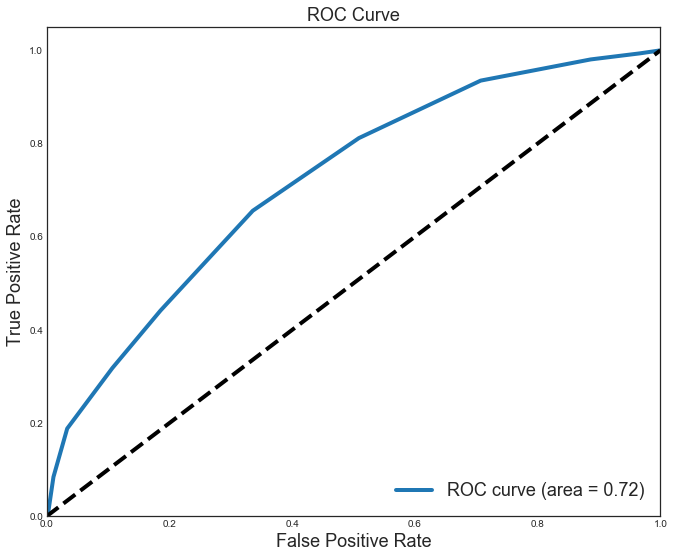

In [36]:
# Let's draw that:
plt.style.use('seaborn-white')
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve', fontsize=18)
plt.legend(loc="lower right", fontsize=18);

## Feature Importance

In [37]:
df_x  = pd.DataFrame(Xvec_test.todense(),
             columns=tvec.get_feature_names())

In [38]:
fi = pd.DataFrame({
        'feature':df_x.columns,
        'importance':my_model.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)

In [39]:
# Features most associated with target
top20=pd.DataFrame(fi.sort_values('importance', ascending=False).head(20))
print(top20['feature'].values)
top20

['horror' 'dead' 'soon' 'remote' 'family' 'old' 'ghost' 'money' 'dr'
 'group' 'young' 'high' 'night' 'life' 'child' 'virus' 'finds' 'zombies'
 'known' 'home']


,feature,importance
4021,horror,0.011500
2161,dead,0.009610
7772,soon,0.007204
6894,remote,0.006993
3090,family,0.006450
5848,old,0.006397
3536,ghost,0.006161
5496,money,0.005277
2553,dr,0.005189
3692,group,0.004844


Text(0, 0.5, 'Feature Importance')

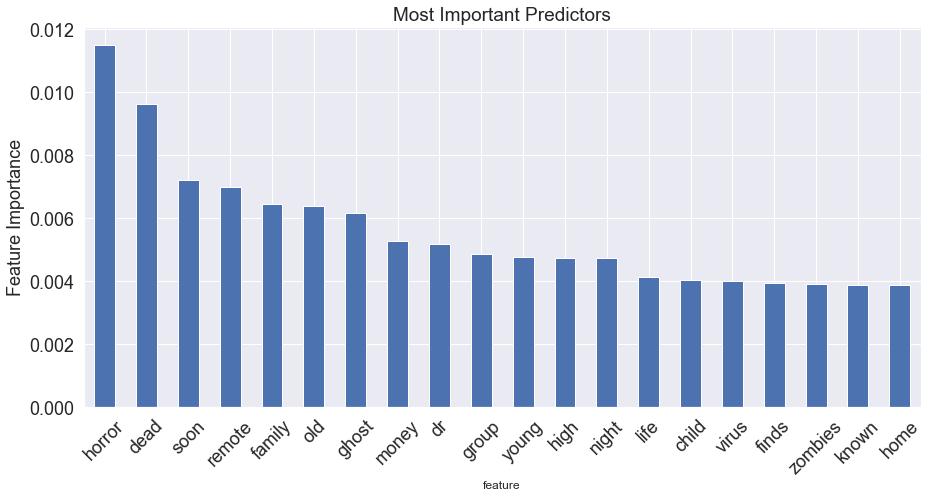

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="darkgrid", color_codes=None)
# sns.palplot(sns.color_palette("RdBu", n_colors=7))
ax = top20.set_index('feature').plot(kind='bar', legend=False, fontsize=18,  figsize=(15, 7))
plt.xticks(rotation = 45,  fontsize=18)
plt.title('Most Important Predictors',  fontsize=19)
plt.yticks(rotation = 0,  fontsize=18)
plt.ylabel('Feature Importance', rotation=90,  fontsize=18)

In [41]:
# save that dataframe
top20.to_csv('top20.csv', index=False)

In [42]:
# Let's display that with Plotly.
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
# import plotly.io as pio
import plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import *

# Define the color palette (19 colors).
Viridis= ['#440154', '#48186a', '#472d7b', '#424086', '#3b528b', '#33638d', '#2c728e', '#26828e', '#21918c', '#1fa088',
          '#28ae80', '#3fbc73', '#5ec962', '#84d44b', '#84d44b', '#addc30','#d8e219', '#fde725',  '#fde725']   

mydata = [go.Bar(
    x=top20['feature'],
    y=top20['importance'],
    marker=dict(color=Viridis[::-1])
)]

mylayout = go.Layout(
    title='What makes it a horror film?',
    xaxis = dict(title = 'Feature Importance'), 
    yaxis = dict(title = 'Top Words'), 

)
fig = go.Figure(data=mydata, layout=mylayout)
# pio.write_image(fig, '../images/logistic.png')
iplot(fig)

In [43]:
# A confusion matrix tells us our false positives and false negatives:
matrix=metrics.confusion_matrix(y_test, y_preds)
cm=pd.DataFrame(matrix, columns=['predicted: no', 'predicted: yes'], index=['ground truth: no', 'ground truth: yes'])
cm=cm.reset_index(drop=False)
cm=cm.rename(columns={'index': f'n = {len(y_test)}'})

In [44]:
import plotly.figure_factory as ff
table = ff.create_table(cm)
iplot(table)

In [45]:
cm.to_csv('conf_matrix.csv', index=False)
cm

,n = 779,predicted: no,predicted: yes
0,ground truth: no,509,116
1,ground truth: yes,86,68


## Test on new data

In [46]:
# newdata = train[train['target']==1]['overview'].sample(1).values
newdata = ['this is a test this is just a test funny funny joke ha']
tvec_test=tvec.transform(newdata)
preds_test=my_model.predict(tvec_test)
preds_test

array([0])

In [47]:
# pickle the vectorizer
file = open('vectorizer.pkl', 'wb')
pickle.dump(tvec, file)
file.close()